---------------------------------------------------------

# PhAst Algorithm (Part 4 of 5): 

#Generating Phase Curves to Determine the Asteroids Absolute Magnitude and Slope Parameter 

## By Arushi Nath

----------------------------------------------

#### This Fourth Notebook will walk you through the steps of Determining the Reduced Magnitude of the asteroid. This will allow for the creation of phase curves to yield asteroid physical properties.


----------------------------------------------

# Sparse Photometry on Asteroids

### 1. Importing Required Libraries

In [1]:
### Import Necessary Libraries
# Here we import all necessary libraries required for data manipulation, numerical calculations, and plotting. Key libraries include:
# - matplotlib.pyplot for plotting graphs.
# - numpy for numerical operations.
# - astropy for astronomy-specific functions such as handling times and units.
# - pandas for data manipulation and reading CSV files.
# - pyedra and sbpy.photometry for specific asteroid curve modeling.

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from astropy.time import Time
import csv
import matplotlib.pyplot as plt
import juliandate as jd
import requests
import pyedra
from astropy.table import Table
from astropy import units as un
import sbpy.photometry as pm
import scipy.optimize as sco
import glob
import pandas as pd
from csv import writer
import io
import requests


## QUERYING GAIA SPACE BASED SKY SURVEY FOR SERENDIPITOUS ASTEROID OBSERVATIONS

### 2. Querying GAIA to Find Asteroids Magnitude and Associated JD

In [2]:
### Data Import and Filtering
# Loading observational data from a CSV file and filtering based on the asteroid of interest. 
# Storing relevant data such as solution ID, source ID, and magnitudes in separate lists for further analysis.
solution_id = []
source_id = []
observation_id = []
MPC = []
epoch_utc = []
g_mag = []
g_flux = []
g_flux_error = []

asteroid = '4786'  # Define the asteroid number

with open(r"combined.csv", newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        if row[5] == asteroid:
            if row[17] != 'null':
                solution_id.append(float(row[0]))
                source_id.append(float(row[1]))
                observation_id.append(float(row[4]))
                MPC.append(float(row[5]))
                epoch_utc.append(float(row[8]))
                g_mag.append(float(row[17]))
                g_flux.append(float(row[18]))
                g_flux_error.append(float(row[19]))

Num = len(MPC)  # Count the number of observations for the specified asteroid


In [3]:
### Conversion to Visual Magnitude
# Convert g-band magnitudes to V-band magnitudes. This cell assumes a direct conversion, which may need adjustment based on specific astronomical standards.



### 3. Taking the Daily Average Magnitude

In [4]:
### Light Curve Averaging
# Processes the light curve data to average the observations by day. This reduces noise and accounts for any discrepancies in observation times. The tqdm library is used to show progress during processing.
v_mag = []
for i in g_mag:
    v_mag.append(i)  # Directly appending g-band magnitudes to V-band list

n = 0
Mag_av = []
epoch_utc_av = []

Mag_avg = []
epoch_utc_avg = []

e2 = epoch_utc.copy()

while n < len(epoch_utc):
    try:
        a = str(np.min(e2))[0:4]

        for s in tqdm(range(len(epoch_utc))):
            print(str(epoch_utc[s])[0:4], a)
            if str(epoch_utc[s])[0:4] == a:
                Mag_av.append(v_mag[s])
                epoch_utc_av.append(epoch_utc[s])
                n += 1
                e2.remove(epoch_utc[s])
        Mag_avg.append(np.average(Mag_av))
        epoch_utc_avg.append(np.average(epoch_utc_av))


  0%|          | 0/242 [00:00<?, ?it/s]

1761 1761
1761 1761
1761 1761
1761 1761
1761 1761
1761 1761
1761 1761
1761 1761
1761 1761
1761 1761
1761 1761
1761 1761
1761 1761
1761 1761
1761 1761
1761 1761
1761 1761
1812 1761
1812 1761
1812 1761
1812 1761
1812 1761
1812 1761
1812 1761
1812 1761
1851 1761
1851 1761
1851 1761
1851 1761
1851 1761
1851 1761
1851 1761
1851 1761
1851 1761
1851 1761
1851 1761
1851 1761
1862 1761
1862 1761
1862 1761
1862 1761
1862 1761
1862 1761
1862 1761
1862 1761
1862 1761
1862 1761
1862 1761
1862 1761
1862 1761
1862 1761
1862 1761
1862 1761
1862 1761
1862 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2021 1761
2072 1761
2072 1761
2072 1761
2072 1761
2072 1761
2103 1761
2103 1761
2103 1761
2103 1761


  0%|          | 0/242 [00:00<?, ?it/s]

1761 1812
1761 1812
1761 1812
1761 1812
1761 1812
1761 1812
1761 1812
1761 1812
1761 1812
1761 1812
1761 1812
1761 1812
1761 1812
1761 1812
1761 1812
1761 1812
1761 1812
1812 1812
1812 1812
1812 1812
1812 1812
1812 1812
1812 1812
1812 1812
1812 1812
1851 1812
1851 1812
1851 1812
1851 1812
1851 1812
1851 1812
1851 1812
1851 1812
1851 1812
1851 1812
1851 1812
1851 1812
1862 1812
1862 1812
1862 1812
1862 1812
1862 1812
1862 1812
1862 1812
1862 1812
1862 1812
1862 1812
1862 1812
1862 1812
1862 1812
1862 1812
1862 1812
1862 1812
1862 1812
1862 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2021 1812
2072 1812
2072 1812
2072 1812
2072 1812
2072 1812
2103 1812
2103 1812
2103 1812
2103 1812


  0%|          | 0/242 [00:00<?, ?it/s]

1761 1851
1761 1851
1761 1851
1761 1851
1761 1851
1761 1851
1761 1851
1761 1851
1761 1851
1761 1851
1761 1851
1761 1851
1761 1851
1761 1851
1761 1851
1761 1851
1761 1851
1812 1851
1812 1851
1812 1851
1812 1851
1812 1851
1812 1851
1812 1851
1812 1851
1851 1851
1851 1851
1851 1851
1851 1851
1851 1851
1851 1851
1851 1851
1851 1851
1851 1851
1851 1851
1851 1851
1851 1851
1862 1851
1862 1851
1862 1851
1862 1851
1862 1851
1862 1851
1862 1851
1862 1851
1862 1851
1862 1851
1862 1851
1862 1851
1862 1851
1862 1851
1862 1851
1862 1851
1862 1851
1862 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2021 1851
2072 1851
2072 1851
2072 1851
2072 1851
2072 1851
2103 1851
2103 1851
2103 1851
2103 1851


  0%|          | 0/242 [00:00<?, ?it/s]

1761 1862
1761 1862
1761 1862
1761 1862
1761 1862
1761 1862
1761 1862
1761 1862
1761 1862
1761 1862
1761 1862
1761 1862
1761 1862
1761 1862
1761 1862
1761 1862
1761 1862
1812 1862
1812 1862
1812 1862
1812 1862
1812 1862
1812 1862
1812 1862
1812 1862
1851 1862
1851 1862
1851 1862
1851 1862
1851 1862
1851 1862
1851 1862
1851 1862
1851 1862
1851 1862
1851 1862
1851 1862
1862 1862
1862 1862
1862 1862
1862 1862
1862 1862
1862 1862
1862 1862
1862 1862
1862 1862
1862 1862
1862 1862
1862 1862
1862 1862
1862 1862
1862 1862
1862 1862
1862 1862
1862 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2021 1862
2072 1862
2072 1862
2072 1862
2072 1862
2072 1862
2103 1862
2103 1862
2103 1862
2103 1862


  0%|          | 0/242 [00:00<?, ?it/s]

1761 2021
1761 2021
1761 2021
1761 2021
1761 2021
1761 2021
1761 2021
1761 2021
1761 2021
1761 2021
1761 2021
1761 2021
1761 2021
1761 2021
1761 2021
1761 2021
1761 2021
1812 2021
1812 2021
1812 2021
1812 2021
1812 2021
1812 2021
1812 2021
1812 2021
1851 2021
1851 2021
1851 2021
1851 2021
1851 2021
1851 2021
1851 2021
1851 2021
1851 2021
1851 2021
1851 2021
1851 2021
1862 2021
1862 2021
1862 2021
1862 2021
1862 2021
1862 2021
1862 2021
1862 2021
1862 2021
1862 2021
1862 2021
1862 2021
1862 2021
1862 2021
1862 2021
1862 2021
1862 2021
1862 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2021 2021
2072 2021
2072 2021
2072 2021
2072 2021
2072 2021
2103 2021
2103 2021
2103 2021
2103 2021


  0%|          | 0/242 [00:00<?, ?it/s]

1761 2072
1761 2072
1761 2072
1761 2072
1761 2072
1761 2072
1761 2072
1761 2072
1761 2072
1761 2072
1761 2072
1761 2072
1761 2072
1761 2072
1761 2072
1761 2072
1761 2072
1812 2072
1812 2072
1812 2072
1812 2072
1812 2072
1812 2072
1812 2072
1812 2072
1851 2072
1851 2072
1851 2072
1851 2072
1851 2072
1851 2072
1851 2072
1851 2072
1851 2072
1851 2072
1851 2072
1851 2072
1862 2072
1862 2072
1862 2072
1862 2072
1862 2072
1862 2072
1862 2072
1862 2072
1862 2072
1862 2072
1862 2072
1862 2072
1862 2072
1862 2072
1862 2072
1862 2072
1862 2072
1862 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2021 2072
2072 2072
2072 2072
2072 2072
2072 2072
2072 2072
2103 2072
2103 2072
2103 2072
2103 2072


  0%|          | 0/242 [00:00<?, ?it/s]

1761 2103
1761 2103
1761 2103
1761 2103
1761 2103
1761 2103
1761 2103
1761 2103
1761 2103
1761 2103
1761 2103
1761 2103
1761 2103
1761 2103
1761 2103
1761 2103
1761 2103
1812 2103
1812 2103
1812 2103
1812 2103
1812 2103
1812 2103
1812 2103
1812 2103
1851 2103
1851 2103
1851 2103
1851 2103
1851 2103
1851 2103
1851 2103
1851 2103
1851 2103
1851 2103
1851 2103
1851 2103
1862 2103
1862 2103
1862 2103
1862 2103
1862 2103
1862 2103
1862 2103
1862 2103
1862 2103
1862 2103
1862 2103
1862 2103
1862 2103
1862 2103
1862 2103
1862 2103
1862 2103
1862 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2021 2103
2072 2103
2072 2103
2072 2103
2072 2103
2072 2103
2103 2103
2103 2103
2103 2103
2103 2103


  0%|          | 0/242 [00:00<?, ?it/s]

1761 2125
1761 2125
1761 2125
1761 2125
1761 2125
1761 2125
1761 2125
1761 2125
1761 2125
1761 2125
1761 2125
1761 2125
1761 2125
1761 2125
1761 2125
1761 2125
1761 2125
1812 2125
1812 2125
1812 2125
1812 2125
1812 2125
1812 2125
1812 2125
1812 2125
1851 2125
1851 2125
1851 2125
1851 2125
1851 2125
1851 2125
1851 2125
1851 2125
1851 2125
1851 2125
1851 2125
1851 2125
1862 2125
1862 2125
1862 2125
1862 2125
1862 2125
1862 2125
1862 2125
1862 2125
1862 2125
1862 2125
1862 2125
1862 2125
1862 2125
1862 2125
1862 2125
1862 2125
1862 2125
1862 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2021 2125
2072 2125
2072 2125
2072 2125
2072 2125
2072 2125
2103 2125
2103 2125
2103 2125
2103 2125


  0%|          | 0/242 [00:00<?, ?it/s]

1761 2208
1761 2208
1761 2208
1761 2208
1761 2208
1761 2208
1761 2208
1761 2208
1761 2208
1761 2208
1761 2208
1761 2208
1761 2208
1761 2208
1761 2208
1761 2208
1761 2208
1812 2208
1812 2208
1812 2208
1812 2208
1812 2208
1812 2208
1812 2208
1812 2208
1851 2208
1851 2208
1851 2208
1851 2208
1851 2208
1851 2208
1851 2208
1851 2208
1851 2208
1851 2208
1851 2208
1851 2208
1862 2208
1862 2208
1862 2208
1862 2208
1862 2208
1862 2208
1862 2208
1862 2208
1862 2208
1862 2208
1862 2208
1862 2208
1862 2208
1862 2208
1862 2208
1862 2208
1862 2208
1862 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2021 2208
2072 2208
2072 2208
2072 2208
2072 2208
2072 2208
2103 2208
2103 2208
2103 2208
2103 2208


  0%|          | 0/242 [00:00<?, ?it/s]

1761 2215
1761 2215
1761 2215
1761 2215
1761 2215
1761 2215
1761 2215
1761 2215
1761 2215
1761 2215
1761 2215
1761 2215
1761 2215
1761 2215
1761 2215
1761 2215
1761 2215
1812 2215
1812 2215
1812 2215
1812 2215
1812 2215
1812 2215
1812 2215
1812 2215
1851 2215
1851 2215
1851 2215
1851 2215
1851 2215
1851 2215
1851 2215
1851 2215
1851 2215
1851 2215
1851 2215
1851 2215
1862 2215
1862 2215
1862 2215
1862 2215
1862 2215
1862 2215
1862 2215
1862 2215
1862 2215
1862 2215
1862 2215
1862 2215
1862 2215
1862 2215
1862 2215
1862 2215
1862 2215
1862 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2021 2215
2072 2215
2072 2215
2072 2215
2072 2215
2072 2215
2103 2215
2103 2215
2103 2215
2103 2215


  0%|          | 0/242 [00:00<?, ?it/s]

1761 2254
1761 2254
1761 2254
1761 2254
1761 2254
1761 2254
1761 2254
1761 2254
1761 2254
1761 2254
1761 2254
1761 2254
1761 2254
1761 2254
1761 2254
1761 2254
1761 2254
1812 2254
1812 2254
1812 2254
1812 2254
1812 2254
1812 2254
1812 2254
1812 2254
1851 2254
1851 2254
1851 2254
1851 2254
1851 2254
1851 2254
1851 2254
1851 2254
1851 2254
1851 2254
1851 2254
1851 2254
1862 2254
1862 2254
1862 2254
1862 2254
1862 2254
1862 2254
1862 2254
1862 2254
1862 2254
1862 2254
1862 2254
1862 2254
1862 2254
1862 2254
1862 2254
1862 2254
1862 2254
1862 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2021 2254
2072 2254
2072 2254
2072 2254
2072 2254
2072 2254
2103 2254
2103 2254
2103 2254
2103 2254


  0%|          | 0/242 [00:00<?, ?it/s]

1761 2289
1761 2289
1761 2289
1761 2289
1761 2289
1761 2289
1761 2289
1761 2289
1761 2289
1761 2289
1761 2289
1761 2289
1761 2289
1761 2289
1761 2289
1761 2289
1761 2289
1812 2289
1812 2289
1812 2289
1812 2289
1812 2289
1812 2289
1812 2289
1812 2289
1851 2289
1851 2289
1851 2289
1851 2289
1851 2289
1851 2289
1851 2289
1851 2289
1851 2289
1851 2289
1851 2289
1851 2289
1862 2289
1862 2289
1862 2289
1862 2289
1862 2289
1862 2289
1862 2289
1862 2289
1862 2289
1862 2289
1862 2289
1862 2289
1862 2289
1862 2289
1862 2289
1862 2289
1862 2289
1862 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2021 2289
2072 2289
2072 2289
2072 2289
2072 2289
2072 2289
2103 2289
2103 2289
2103 2289
2103 2289


  0%|          | 0/242 [00:00<?, ?it/s]

1761 2307
1761 2307
1761 2307
1761 2307
1761 2307
1761 2307
1761 2307
1761 2307
1761 2307
1761 2307
1761 2307
1761 2307
1761 2307
1761 2307
1761 2307
1761 2307
1761 2307
1812 2307
1812 2307
1812 2307
1812 2307
1812 2307
1812 2307
1812 2307
1812 2307
1851 2307
1851 2307
1851 2307
1851 2307
1851 2307
1851 2307
1851 2307
1851 2307
1851 2307
1851 2307
1851 2307
1851 2307
1862 2307
1862 2307
1862 2307
1862 2307
1862 2307
1862 2307
1862 2307
1862 2307
1862 2307
1862 2307
1862 2307
1862 2307
1862 2307
1862 2307
1862 2307
1862 2307
1862 2307
1862 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2021 2307
2072 2307
2072 2307
2072 2307
2072 2307
2072 2307
2103 2307
2103 2307
2103 2307
2103 2307


  0%|          | 0/242 [00:00<?, ?it/s]

1761 2518
1761 2518
1761 2518
1761 2518
1761 2518
1761 2518
1761 2518
1761 2518
1761 2518
1761 2518
1761 2518
1761 2518
1761 2518
1761 2518
1761 2518
1761 2518
1761 2518
1812 2518
1812 2518
1812 2518
1812 2518
1812 2518
1812 2518
1812 2518
1812 2518
1851 2518
1851 2518
1851 2518
1851 2518
1851 2518
1851 2518
1851 2518
1851 2518
1851 2518
1851 2518
1851 2518
1851 2518
1862 2518
1862 2518
1862 2518
1862 2518
1862 2518
1862 2518
1862 2518
1862 2518
1862 2518
1862 2518
1862 2518
1862 2518
1862 2518
1862 2518
1862 2518
1862 2518
1862 2518
1862 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2021 2518
2072 2518
2072 2518
2072 2518
2072 2518
2072 2518
2103 2518
2103 2518
2103 2518
2103 2518


  0%|          | 0/242 [00:00<?, ?it/s]

1761 2534
1761 2534
1761 2534
1761 2534
1761 2534
1761 2534
1761 2534
1761 2534
1761 2534
1761 2534
1761 2534
1761 2534
1761 2534
1761 2534
1761 2534
1761 2534
1761 2534
1812 2534
1812 2534
1812 2534
1812 2534
1812 2534
1812 2534
1812 2534
1812 2534
1851 2534
1851 2534
1851 2534
1851 2534
1851 2534
1851 2534
1851 2534
1851 2534
1851 2534
1851 2534
1851 2534
1851 2534
1862 2534
1862 2534
1862 2534
1862 2534
1862 2534
1862 2534
1862 2534
1862 2534
1862 2534
1862 2534
1862 2534
1862 2534
1862 2534
1862 2534
1862 2534
1862 2534
1862 2534
1862 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2021 2534
2072 2534
2072 2534
2072 2534
2072 2534
2072 2534
2103 2534
2103 2534
2103 2534
2103 2534


  0%|          | 0/242 [00:00<?, ?it/s]

1761 2601
1761 2601
1761 2601
1761 2601
1761 2601
1761 2601
1761 2601
1761 2601
1761 2601
1761 2601
1761 2601
1761 2601
1761 2601
1761 2601
1761 2601
1761 2601
1761 2601
1812 2601
1812 2601
1812 2601
1812 2601
1812 2601
1812 2601
1812 2601
1812 2601
1851 2601
1851 2601
1851 2601
1851 2601
1851 2601
1851 2601
1851 2601
1851 2601
1851 2601
1851 2601
1851 2601
1851 2601
1862 2601
1862 2601
1862 2601
1862 2601
1862 2601
1862 2601
1862 2601
1862 2601
1862 2601
1862 2601
1862 2601
1862 2601
1862 2601
1862 2601
1862 2601
1862 2601
1862 2601
1862 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2021 2601
2072 2601
2072 2601
2072 2601
2072 2601
2072 2601
2103 2601
2103 2601
2103 2601
2103 2601


  0%|          | 0/242 [00:00<?, ?it/s]

1761 2624
1761 2624
1761 2624
1761 2624
1761 2624
1761 2624
1761 2624
1761 2624
1761 2624
1761 2624
1761 2624
1761 2624
1761 2624
1761 2624
1761 2624
1761 2624
1761 2624
1812 2624
1812 2624
1812 2624
1812 2624
1812 2624
1812 2624
1812 2624
1812 2624
1851 2624
1851 2624
1851 2624
1851 2624
1851 2624
1851 2624
1851 2624
1851 2624
1851 2624
1851 2624
1851 2624
1851 2624
1862 2624
1862 2624
1862 2624
1862 2624
1862 2624
1862 2624
1862 2624
1862 2624
1862 2624
1862 2624
1862 2624
1862 2624
1862 2624
1862 2624
1862 2624
1862 2624
1862 2624
1862 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2021 2624
2072 2624
2072 2624
2072 2624
2072 2624
2072 2624
2103 2624
2103 2624
2103 2624
2103 2624


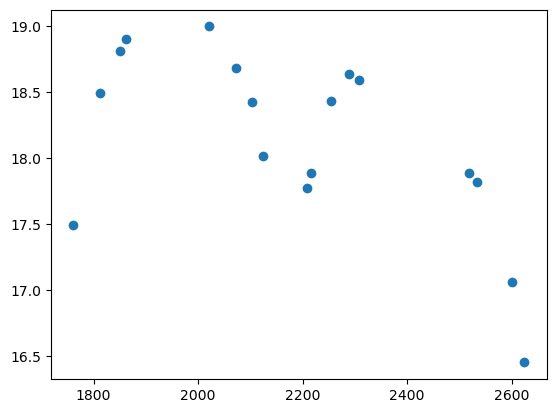

In [5]:
plt.scatter(epoch_utc_avg, Mag_avg)

In [6]:
### Convert and Adjust Data for Analysis by Converting to Julian Date

mag = []  # List to store adjusted magnitudes
JD = []   # List to store Julian Dates converted from epoch data

for i in Mag_avg:
    mag.append(i)

# Converting epoch data to Julian Date format by adding a constant offset. This is a common practice in astronomy to align dates with a standard epoch.
# 2455197.5 represents the Julian Date for a specific reference time, which needs to be adjusted based on the epoch data's starting point.
for i in epoch_utc_avg:
    JD.append(i + 2455197.5)

### 4. Applying Unity Offsets to Account for Changing Distances

In [7]:
### Generate API Link for Asteroid Phase Angle Data
# This function constructs a URL for querying the JPL Horizons system to retrieve phase angle data for a specified asteroid over a given time range.
# The function takes three parameters: the asteroid's identifier, the start time, and the end time for the query.

def PA_finder(asteroid, START_TIME, END_TIME):
    sep = ''  # Separator for joining strings; empty string implies direct concatenation without additional characters.

    # Concatenating parts of the API request with the necessary parameters:
    ast_mod = sep.join("&COMMAND=" + asteroid)  # Appending the asteroid identifier to the command part of the URL.
    start_mod = sep.join("&START_TIME=" + START_TIME)  # Appending the start time for the data query.
    end_mod = sep.join("&STOP_TIME=" + END_TIME)  # Appending the end time for the data query.

    # Base URL for the JPL Horizons system, formatted to request data in text format, querying data specifically for the 'Gaia' barycenter.
    start = "https://ssd.jpl.nasa.gov/api/horizons.api?format=text&CENTER='@gaia'&OBJ_DATA=NO&STEP_SIZE='1min'&QUANTITIES='19,20,24'"

    # Combining all parts to form the complete API link:
    link = start, ast_mod, start_mod, end_mod
    link = sep.join(link)  # Joining all parts into a single URL string.
  
    return link  # Returning the full URL for the API request.


In [8]:
### Retrieve and Parse Asteroid Data from API
# This code block queries an API for astronomical data of an asteroid at specified Julian Dates (JD),
# then parses and extracts relevant data such as the distance from the Sun, Earth, and the phase angle.

Sun_dist = []    # List to hold the distance from the Sun
Time_ast = []    # List to hold timestamps of the data
Earth_dist = []  # List to hold the distance from Earth
Phase_Angle = [] # List to hold the phase angle

# Loop through each Julian Date to make an API call and process the returned data
for s in tqdm(range(len(JD))):
    # Setting up start and end times for the API request
    START_TIME = str("JD" + str(JD[s]))
    END_TIME = str("JD" + str(JD[s]+ 0.0007))

    # Print the Julian Date to monitor progress
    print(JD[s])

    # Get the API query URL by calling the PA_finder function
    ast_query = PA_finder(asteroid, START_TIME, END_TIME)

    # Making the API request and getting the response
    response_API = requests.get(ast_query)
    data = response_API.text
    
    # Parsing the data received from the API
    a = data.split("*")
    q = []
    for i in a:
        if i != '':
            q.append(i)
    
    # Extracting the required information from the parsed data
    qs = []
    z = q[-3].split(" ")
    for i in z:
        if i != '':
            qs.append(i)
    
    # Appending the extracted data to their respective lists
    Time_ast.append(qs[2] + " " + qs[1])  # Combining date and time for better readability
    Sun_dist.append(float(qs[3]))        # Distance from the Sun
    Earth_dist.append(float(qs[5]))      # Distance from Earth
    Phase_Angle.append(float(qs[7][:-1]))  # Phase angle, removing the last character assumed to be non-numeric


  0%|          | 0/17 [00:00<?, ?it/s]

2456958.604962139
2457010.128796618
2457048.73955879
2457060.316526625
2457218.8550436427
2457269.7915928694
2457301.0657893163
2457322.564355484
2457406.332112107
2457412.9309837176
2457451.6029977426
2457486.861753431
2457505.1165406653
2457715.609267659
2457731.822317038
2457798.5482452847
2457821.687941124


In [9]:
from astropy.time import Time
t = Time(JD[0], format='jd')
utc = t.to_datetime()

In [12]:
### Applying Unity Offsets to get the Reduced Magnitude of the Asteroid
Unity = []
for i in range(len(mag)):
    
    a = mag[i] - 5*np.log10(Sun_dist[i]*Earth_dist[i])
    Unity.append(a)

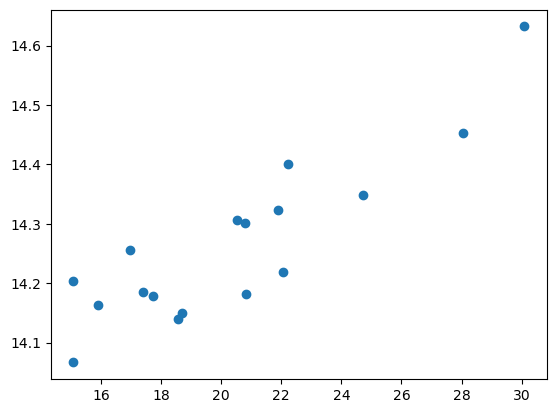

In [15]:
### Plotting Phase Curve
plt.scatter(Phase_Angle, Unity)
#plt.ylim(8.1,7)
plt.show()

In [16]:
paired_sorted = sorted(zip(Phase_Angle, Unity))
Phase_Angle_Final, Unity_Final = zip(*paired_sorted)

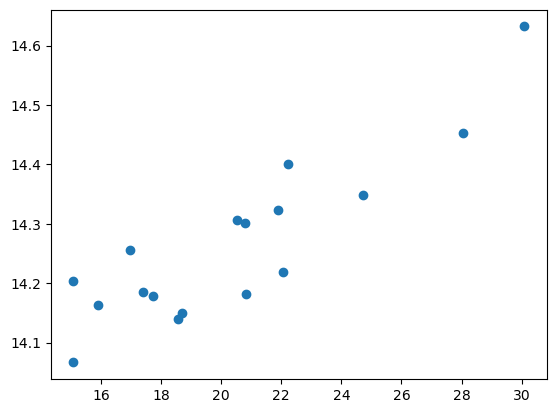

In [17]:
plt.scatter(Phase_Angle_Final, Unity_Final)
#plt.ylim(8.1,7)
plt.show()

### 5. Applying Filter Offsets

In [18]:
### Applying Filter Offsets

t1_GAIA = []
t2_GAIA = []
for i in range(len(Unity_Final)):
    if Phase_Angle_Final[i] <=20:
        a = Unity_Final[i] + 0.02269 - 0.01784*(0.45) + 1.016*(0.45)**2 - 0.2225*(0.45)**3 #V-R
        #a = Unity_Final[i] +0.02907 + 0.02385*(0.684) + 0.2297*(0.684)**2 + 0.001768*(0.684)**3 #B-V
        t1_GAIA.append(Phase_Angle_Final[i])
        t2_GAIA.append(a)
nysa = Table([t1_GAIA,t2_GAIA], names=('phase','V'))
nysa['phase'].unit = 'deg'
nysa['V'].unit = 'mag'
print(nysa)

 phase          V         
  deg          mag        
------- ------------------
15.0732 14.403932392628255
15.0769 14.266696285232022
15.8986 14.363682246564974
16.9491 14.455535324251278
17.3962 14.385566519705494
17.7324 14.377802174122019
18.5682 14.339399254597662
18.6786 14.349387912292675


### 6. Creating H and G Curve

In [19]:
 # Photometric system from sbpy package, photometry submodule
def pf(xdeg,par1,par2):
    return pm.HG.evaluate(xdeg*np.pi/180,par1,par2)
# Sum-of-squares
def sse_fun(x,data):
    return sum([(pf(d[0],x[0],x[1])-d[1])**2 for d in data])
# Fit function
def fit_fun(data, x0=[6,0.12]):
    cv = ({'type': 'ineq', 'fun': lambda x: x[1]},
    {'type': 'ineq', 'fun': lambda x: 1-x[1]})
    return sco.minimize(sse_fun,x0,args=data,constraints=cv,method='COBYLA')


In [20]:
res = fit_fun(nysa)
print("RMS of H,G-fit is {:2.8f}".format(res.fun))
print("Fitted H={:1.4f} and G={:1.6f}".format(res.x[0],res.x[1]))

RMS of H,G-fit is 0.02250487
Fitted H=14.0755 and G=0.850510


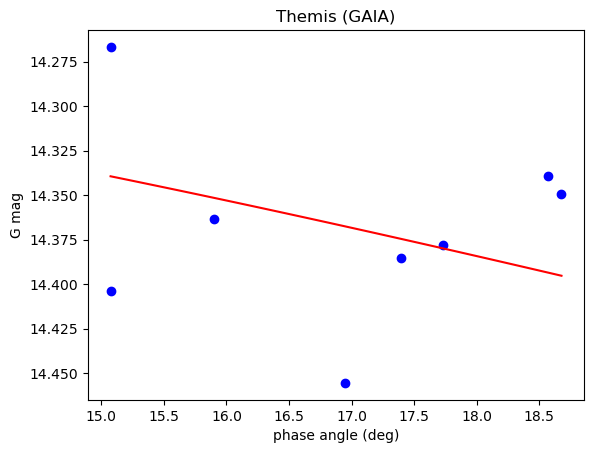

In [21]:
fx=np.linspace(nysa['phase'][0],nysa['phase'][-1],100)
fy=np.array([pf(x,res.x[0],res.x[1]) for x in fx])
g,p1=plt.subplots(1,1)
p1.plot(nysa['phase'],nysa['V'],'bo')
p1.plot(fx,fy,'r')
p1.set_title('Themis (GAIA)')
p1.set_xlabel('phase angle (deg)')
p1.set_ylabel('G mag')
p1.invert_yaxis()

## QUERYING ZTF ALL SKY SURVEY FOR SERENDIPITOUS ASTEROID OBSERVATIONS

### 1. Querying FINK Server

In [22]:
r = requests.post(
  'https://fink-portal.org/api/v1/sso',
  json={
    'n_or_d': asteroid,
    'output-format': 'json',
    #'columns': 'i:jd,i:magpsf'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(io.BytesIO(r.content))

In [23]:
#{"doc":"Filter ID (1=g; 2=R; 3=i)
#V-g = -0.4508 and V-r=0.3379 (with ZTF filters)
JD = []
mag = []
for i in range(len(pdf['i:jd'])):
    if pdf['i:fid'][i]==2:
        JD.append(pdf['i:jd'][i])
    
for i in range(len(pdf['i:magpsf'])):
    if pdf['i:fid'][i]==2:
        
        mag.append((pdf['i:magpsf'][i]))#-0.4508

### 2. Applying Unity Offsets to Get Reduced Magnitude

In [24]:
def PA_finder(asteroid, START_TIME, END_TIME): 

    sep = ''
    ast_mod = sep.join("&COMMAND=" + asteroid)
    start_mod = sep.join("&START_TIME=" + START_TIME)
    end_mod = sep.join("&STOP_TIME=" + END_TIME)
   
    start = "https://ssd.jpl.nasa.gov/api/horizons.api?format=text&OBJ_DATA=NO&STEP_SIZE='1min'&QUANTITIES='19,20,24'"
    link = start, ast_mod, start_mod, end_mod
    link = sep.join(link)
 
    return link

In [25]:
Sun_dist = []
Time_ast = []
Earth_dist = []
Phase_Angle = []
for s in tqdm(range(len(JD))):
  
    START_TIME = str("JD" + str(JD[s]))
    END_TIME = str("JD" + str(JD[s]+ 0.0007))
    print(JD[s])
    ast_query = PA_finder(asteroid, START_TIME, END_TIME)
    
    response_API = requests.get(ast_query)
    data = response_API.text
    
    
    a = data.split("*")
    q = []
    for i in a:
        if i != '':
            q.append(i)
        
    qs = []
    z = q[-3].split(" ")
    for i in z:
        if i != '':
            qs.append(i)
    Time_ast.append(qs[2] + " " + qs[1])
    Sun_dist.append(float(qs[3]))
    Earth_dist.append(float(qs[5]))
    Phase_Angle.append(float(qs[7][:-1]))

  0%|          | 0/128 [00:00<?, ?it/s]

2460398.8819329
2460368.8015046
2460258.0187384
2460253.0065162
2460236.9840741
2460223.0334028
2460223.0310185
2460223.0286343
2460223.0266898
2460223.0241551
2460223.0216204
2460223.0190972
2460223.0165741
2460215.0285417
2460215.0260995
2460215.0236806
2460215.02125
2460215.0188194
2460213.0274421
2460213.0225463
2460213.0201042
2460212.0291782
2460212.0267361
2460212.024294
2460212.0218519
2460212.0193981
2460208.0250926
2460208.0227199
2460208.0203472
2460208.0179861
2460208.0156134
2460207.027419
2460207.0249769
2460207.0225347
2460207.0200926
2460207.0176505
2460204.0239236
2460204.0214931
2460204.0190509
2460204.0141667
2460202.0219444
2460013.72625
2459969.6304051
2459967.6446296
2459965.673206
2459942.7125694
2459936.7147454
2459928.7392245
2459928.7272801
2459922.7749306
2459913.7914583
2459906.8159606
2459904.838044
2459902.8622222
2459899.8021181
2459897.8152315
2459882.8578472
2459871.9009259
2459863.9666319
2459860.9192477
2459858.9997106
2459856.9754282
2459851.9438542


In [26]:
from astropy.time import Time
t = Time(JD[0], format='jd')
utc = t.to_datetime()

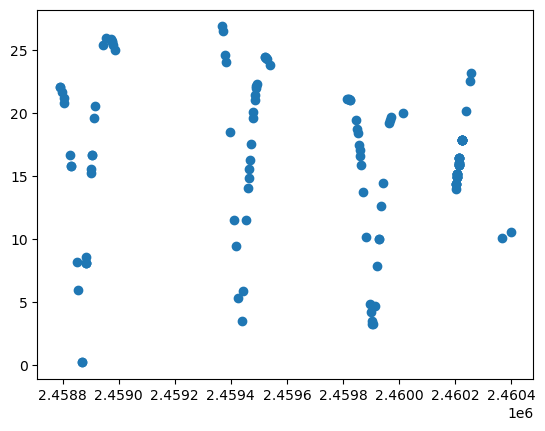

In [27]:
plt.scatter(JD, Phase_Angle)

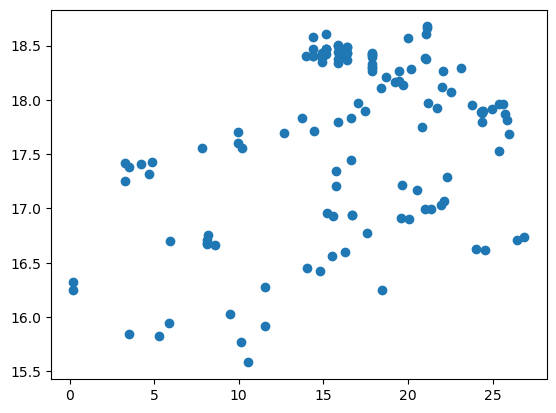

In [28]:
plt.scatter(Phase_Angle, mag)

In [29]:
Unity = []
for i in range(len(mag)):
    
    a = mag[i] - 5*np.log10(Sun_dist[i]*Earth_dist[i])
    Unity.append(a)

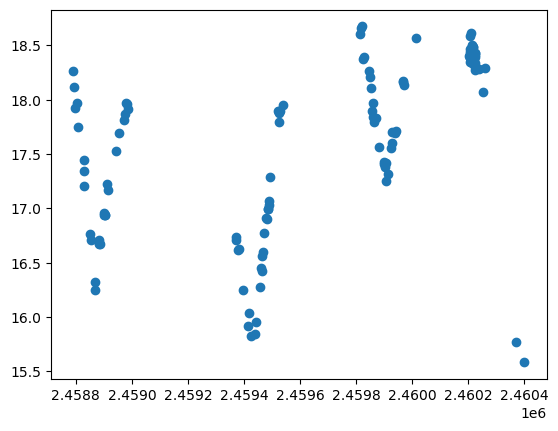

In [30]:
plt.scatter(JD, mag)

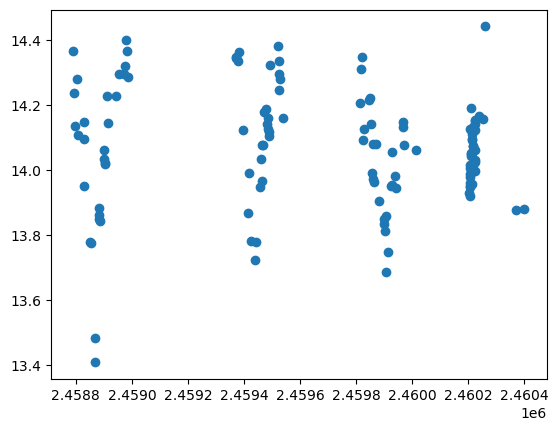

In [31]:
plt.scatter(JD, Unity)

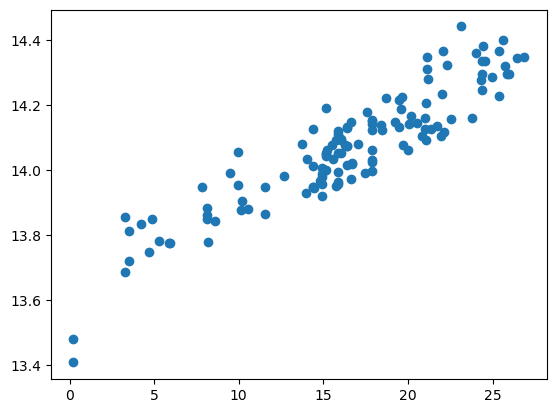

In [32]:
plt.scatter(Phase_Angle, Unity)
#plt.ylim(8.1,7)
plt.show()

In [33]:
paired_sorted = sorted(zip(Phase_Angle, Unity))
Phase_Angle_Final, Unity_Final = zip(*paired_sorted)

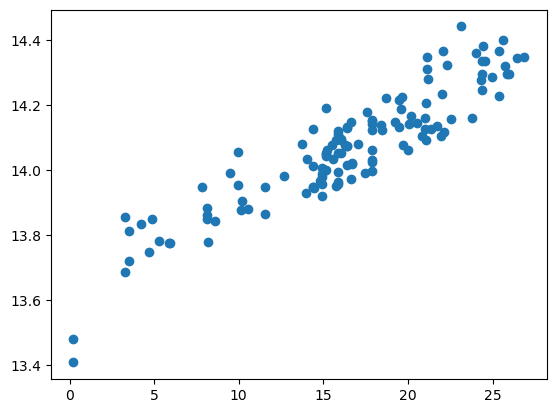

In [34]:
plt.scatter(Phase_Angle, Unity)
#plt.ylim(8.1,7)
plt.show()

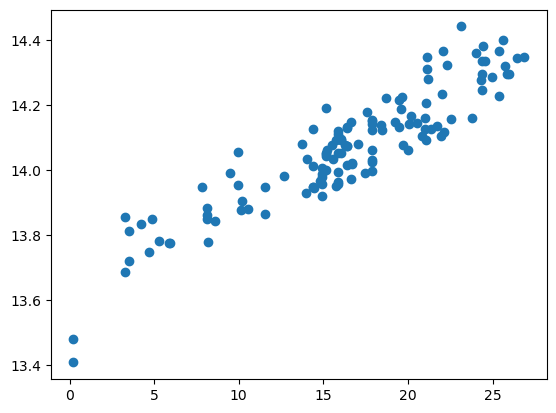

In [35]:
plt.scatter(Phase_Angle_Final, Unity_Final)
#plt.ylim(8.1,7)
plt.show()

### 3. Applying Filter Offsets

In [36]:

t2_ZTF = []
t1_ZTF = []
for i in range(len(Unity_Final)):
    if float(Phase_Angle_Final[i]) <=20:
        t2_ZTF.append(Unity_Final[i]+0.3379)
       
        t1_ZTF.append(Phase_Angle_Final[i])
    
nysa = Table([t1_ZTF,t2_ZTF], names=('phase','V'))
nysa['phase'].unit = 'deg'
nysa['V'].unit = 'mag'
print(nysa)

 phase          V         
  deg          mag        
------- ------------------
 0.2159 13.745412563046008
 0.2232 13.819094482776121
 3.2508 14.194737524990883
 3.2811  14.02281104172611
  3.513  14.05922218828576
 3.5304 14.151014440878201
 4.2434 14.172145968865447
 4.6654 14.085166304054898
  4.842 14.188049874171655
 5.2943 14.119981186365512
    ...                ...
17.8523 14.333824511994353
18.4073 14.478346012398363
18.4678 14.461744126406941
18.7313 14.560887700185566
19.2161 14.485887178756444
19.4626 14.554532535187251
19.4711 14.471649081231758
19.5744 14.526111458764577
19.6262 14.564514417114578
19.7046 14.414075681117662
Length = 90 rows


### 4. Creating H and G Curve

In [37]:
res = fit_fun(nysa)
print("RMS of H,G-fit is {:2.8f}".format(res.fun))
print("Fitted H={:1.4f} and G={:1.6f}".format(res.x[0],res.x[1]))

RMS of H,G-fit is 0.36518569
Fitted H=13.8257 and G=0.461250


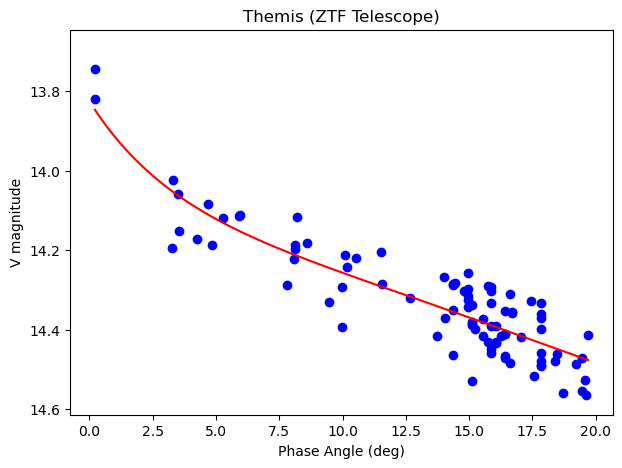

In [38]:
fx=np.linspace(nysa['phase'][0],nysa['phase'][-1],100)
fy=np.array([pf(x,res.x[0],res.x[1]) for x in fx])
#g,p1=plt.subplots(1,1)
plt.figure(figsize=(7, 5))
plt.plot(nysa['phase'],nysa['V'],'bo')
plt.plot(fx,fy,'r')
plt.title('Themis (ZTF Telescope)')
plt.xlabel('Phase Angle (deg)')
plt.ylabel('V magnitude')
plt.ylim(max(nysa['V']+0.05), min(nysa['V']-0.1))
plt.show()

## QUERYING ALCDEF OBSERVATIONS

### 1. Querying File for All ALCDEF Observations of Didymos

In [142]:
g_mag = []
JD2 = []
epoch_utc = []
Error = []
Color = []
with open(r"Tatianina SPARSE.csv", newline='') as f:
  reader = csv.reader(f)
  for row in reader:
      
    print(row)
    
    g_mag.append((row[1]))
    
    epoch_utc.append((row[0]))
    
    
    #Color.append(row[3])
g_mag = g_mag[1:]
g_mag = [eval(i) for i in g_mag]

epoch_utc = epoch_utc[1:]

epoch_utc = [eval(i) for i in epoch_utc]

Error = Error[1:]
Error = [eval(i) for i in Error]

['JD', 'Mag', 'MagErr']
['2453815.642847', '0.417000', '0.015000']
['2453815.651100', '0.535000', '0.016000']
['2453815.658900', '0.417000', '0.014000']
['2453815.667512', '0.372000', '0.012000']
['2453815.675197', '0.350000', '0.012000']
['2453815.676505', '0.326000', '0.012000']
['2453815.684167', '0.391000', '0.012000']
['2453815.685486', '0.382000', '0.012000']
['2453815.695023', '0.422000', '0.012000']
['2453815.696343', '0.425000', '0.012000']
['2453815.704086', '0.512000', '0.013000']
['2453815.705393', '0.507000', '0.012000']
['2453815.713090', '0.516000', '0.012000']
['2453815.714398', '0.515000', '0.012000']
['2453815.722083', '0.418000', '0.012000']
['2453815.723380', '0.419000', '0.012000']
['2453815.732720', '0.351000', '0.012000']
['2453815.734039', '0.371000', '0.022000']
['2453815.736400', '0.355000', '0.012000']
['2453815.737708', '0.369000', '0.012000']
['2453815.740069', '0.380000', '0.012000']
['2453815.741377', '0.401000', '0.013000']
['2453815.743819', '0.396000',

In [143]:
n = 0
Mag_av = []
epoch_utc_av = []

Mag_avg = []
epoch_utc_avg = []

e2 = epoch_utc.copy()

while n< len(epoch_utc):
    try:
        a = str(np.min(e2))[0:7]
    
        for s in tqdm(range(len(epoch_utc))):
            print(str(epoch_utc[s])[0:7], a)
            if str(epoch_utc[s])[0:7] == a:
    
            
                Mag_av.append(g_mag[s])
                epoch_utc_av.append(epoch_utc[s])
                n+=1
                e2.remove(epoch_utc[s])
        Mag_avg.append(np.average(Mag_av))
        epoch_utc_avg.append(np.average(epoch_utc_av))
        Mag_av = []
        epoch_utc_av = []

    except:
        pass

  0%|          | 0/475 [00:00<?, ?it/s]

2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 2453815
2453815 

  0%|          | 0/475 [00:00<?, ?it/s]

2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 2453823
2453815 

  0%|          | 0/475 [00:00<?, ?it/s]

2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 2453828
2453815 

  0%|          | 0/475 [00:00<?, ?it/s]

2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 2453830
2453815 

  0%|          | 0/475 [00:00<?, ?it/s]

2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 2453832
2453815 

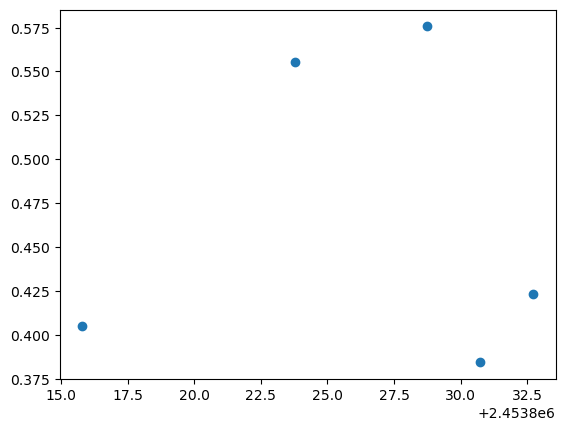

In [144]:
plt.scatter(epoch_utc_avg, Mag_avg)

In [145]:
mag = []
JD = []
for i in Mag_avg:
    mag.append(i)
for i in epoch_utc_avg:
    JD.append(i)

### 2. Applying Unity Offsets to get Reduced Magnitude

In [146]:
def PA_finder(asteroid, START_TIME, END_TIME): 

    sep = ''
    ast_mod = sep.join("&COMMAND=" + asteroid)
    start_mod = sep.join("&START_TIME=" + START_TIME)
    end_mod = sep.join("&STOP_TIME=" + END_TIME)
   
    start = "https://ssd.jpl.nasa.gov/api/horizons.api?format=text&OBJ_DATA=NO&STEP_SIZE='1min'&QUANTITIES='19,20,24'"
    link = start, ast_mod, start_mod, end_mod
    link = sep.join(link)
 
    return link

In [147]:
### Collect and Process Astronomical Data
# This code retrieves specific astronomical data for an asteroid at given times and processes it to extract distances and phase angles.

Sun_dist = []    # List to store distances from the Sun
Time_ast = []    # List to store time of each data point
Earth_dist = []  # List to store distances from Earth
Phase_Angle = [] # List to store phase angles

# Loop through each Julian Date to query astronomical data
for s in tqdm(range(len(JD))):
    # Construct API request times based on the Julian Date
    START_TIME = "JD" + str(JD[s])
    END_TIME = "JD" + str(JD[s] + 0.0007)  # Small increment to define a range around the given JD
    print(JD[s])  # Output current Julian Date being processed

    # Generate the API request URL
    ast_query = PA_finder(asteroid, START_TIME, END_TIME)
    
    # Send the API request and capture the response
    response_API = requests.get(ast_query)
    data = response_API.text  # API response text
    
    # Split the response text to parse the relevant data
    a = data.split("*")
    q = [i for i in a if i]  # Filter out empty strings from the split results
    
    # Parse the specific data segment from the response
    qs = []
    z = q[-3].split(" ")  # Select the third-last item from 'q' and split it by spaces
    qs = [i for i in z if i]  # Filter out empty strings from 'z'
    
    # Extract and store the specific data elements
    Time_ast.append(qs[2] + " " + qs[1])  # Combine date and time for better readability
    Sun_dist.append(float(qs[3]))  # Convert the Sun distance to float and store
    Earth_dist.append(float(qs[5]))  # Convert the Earth distance to float and store
    Phase_Angle.append(float(qs[7][:-1]))  # Extract the phase angle, remove the last character, convert to float and store


  0%|          | 0/5 [00:00<?, ?it/s]

2453815.7981
2453823.7776019457
2453828.747762423
2453830.729278129
2453832.7118134224


In [148]:
from astropy.time import Time
t = Time(JD[0], format='jd')
utc = t.to_datetime()

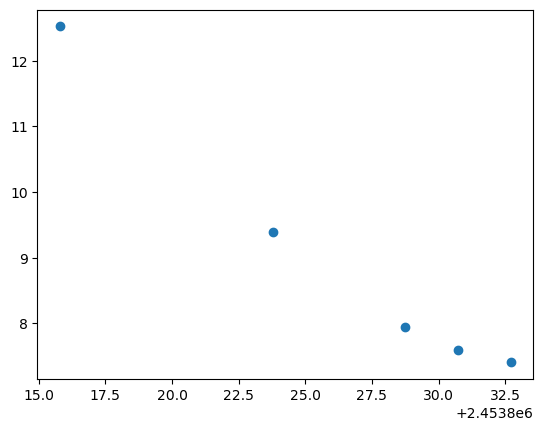

In [149]:
plt.scatter(JD, Phase_Angle)

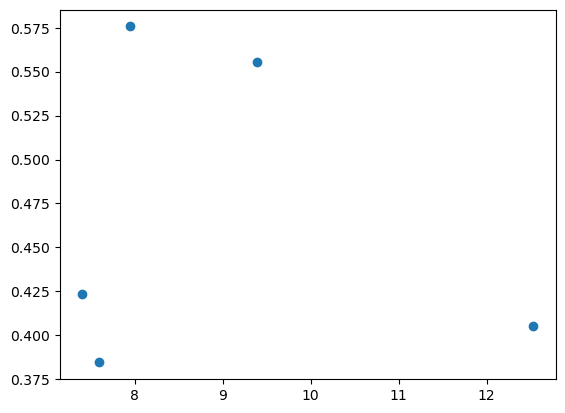

In [150]:
plt.scatter(Phase_Angle, mag)

In [151]:
Unity = []
for i in range(len(mag)):
    
    a = mag[i] - 5*np.log10(Sun_dist[i]*Earth_dist[i])
    Unity.append(a)

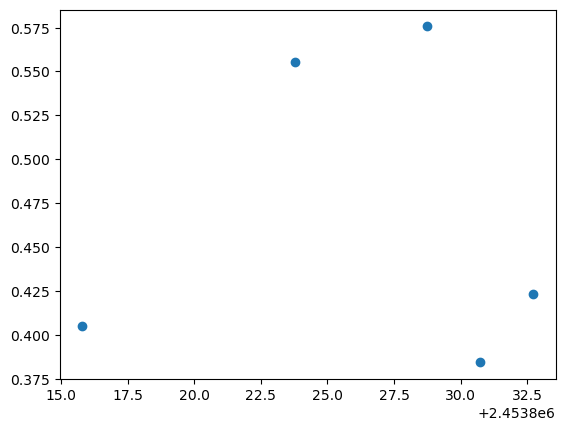

In [152]:
plt.scatter(JD, mag)

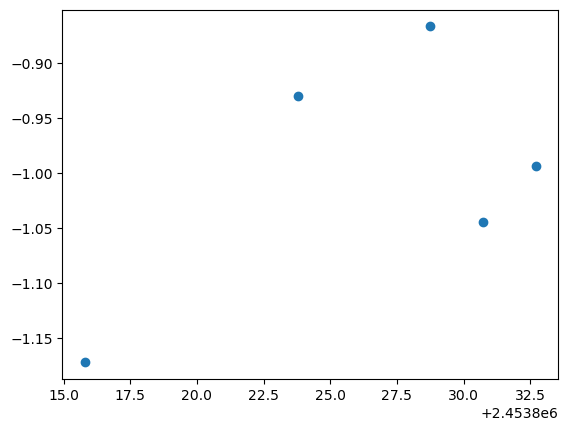

In [153]:
plt.scatter(JD, Unity)

In [154]:
paired_sorted = sorted(zip(Phase_Angle, Unity))
Phase_Angle_Final, Unity_Final = zip(*paired_sorted)

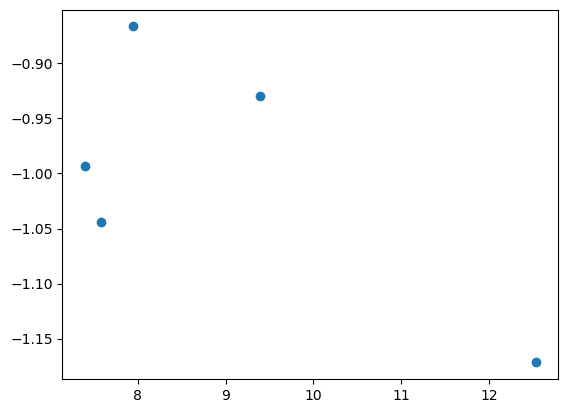

In [155]:
plt.scatter(Phase_Angle, Unity)
#plt.ylim(8.1,7)
plt.show()

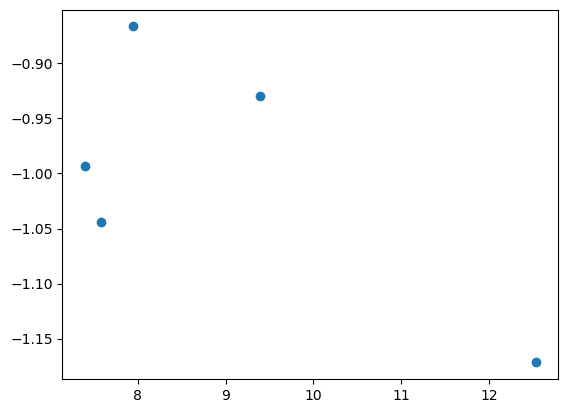

In [156]:
plt.scatter(Phase_Angle_Final, Unity_Final)
#plt.ylim(8.1,7)
plt.show()

### 3. Applying Filter Offsets

In [194]:
### Applying Filter Conversions for ALCDEF data

t2_ALCDEF = []
t1_ALCDEF = Phase_Angle_Final
for i in Unity_Final:
    t2_ALCDEF.append(i+1.18)
nysa = Table([t1_ALCDEF,t2_ALCDEF], names=('phase','V'))
nysa['phase'].unit = 'deg'
nysa['V'].unit = 'mag'
print(nysa)

 phase          V         
  deg          mag        
------- ------------------
 7.4015 14.186623582700417
 7.5891 14.136050813260702
 7.9438 14.313477421169704
 9.3881 14.250229300421088
12.5276  14.00833656355119


### 4. Creating H and G Curves

In [195]:
res = fit_fun(nysa)
print("RMS of H,G-fit is {:2.8f}".format(res.fun))
print("Fitted H={:1.4f} and G={:1.6f}".format(res.x[0],res.x[1]))

RMS of H,G-fit is 0.06504704
Fitted H=14.0597 and G=1.000000


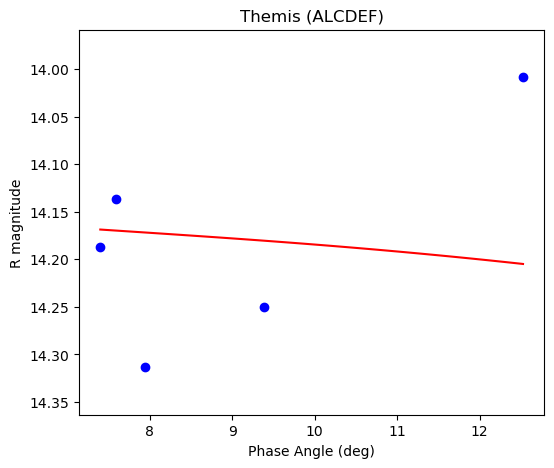

In [196]:
fx=np.linspace(nysa['phase'][0],nysa['phase'][-1],100)
fy=np.array([pf(x,res.x[0],res.x[1]) for x in fx])
#g,p1=plt.subplots(1,1)
plt.figure(figsize=(6, 5))
plt.plot(nysa['phase'],nysa['V'],'bo')
plt.plot(fx,fy,'r')
plt.title('Themis (ALCDEF)')
plt.xlabel('Phase Angle (deg)')
plt.ylabel('R magnitude')
plt.ylim(max(nysa['V']+0.05), min(nysa['V']-0.05))
plt.show()

## COMBINING ALL SKY SURVEYS AND CITIZEN SCIENTIST OBSERVATIONS

In [197]:
phase_angle_total = []
unity_total = []

for i in range(len(t1_GAIA)):
    phase_angle_total.append(t1_GAIA[i])
    unity_total.append(t2_GAIA[i])
for i in range(len(t1_ZTF)):
    phase_angle_total.append(t1_ZTF[i])
    unity_total.append(t2_ZTF[i])
for i in range(len(t1_ALCDEF[-2:-1])):
    phase_angle_total.append(t1_ALCDEF[i])
    unity_total.append(t2_ALCDEF[i])

In [198]:
paired_sorted = sorted(zip(phase_angle_total, unity_total))
t1_total, t2_total = zip(*paired_sorted)

In [199]:
nysa = Table([t1_total[0:-1],t2_total[0:-1]], names=('phase','V'))
nysa['phase'].unit = 'deg'
nysa['V'].unit = 'mag'
print(nysa)

 phase          V         
  deg          mag        
------- ------------------
 0.2159 13.745412563046008
 0.2232 13.819094482776121
 3.2508 14.194737524990883
 3.2811  14.02281104172611
  3.513  14.05922218828576
 3.5304 14.151014440878201
 4.2434 14.172145968865447
 4.6654 14.085166304054898
  4.842 14.188049874171655
 5.2943 14.119981186365512
    ...                ...
18.4073 14.478346012398363
18.4678 14.461744126406941
18.5682 14.339399254597662
18.6786 14.349387912292675
18.7313 14.560887700185566
19.2161 14.485887178756444
19.4626 14.554532535187251
19.4711 14.471649081231758
19.5744 14.526111458764577
19.6262 14.564514417114578
Length = 98 rows


In [200]:
res = fit_fun(nysa)
print("RMS of H,G-fit is {:2.8f}".format(res.fun))
print("Fitted H={:1.4f} and G={:1.6f}".format(res.x[0],res.x[1]))

RMS of H,G-fit is 0.40218099
Fitted H=13.8298 and G=0.471084


In [201]:
x_specific = nysa['phase'] 
# Calculate fitted y values for these specific x values
fy_specific = np.array([pf(x, res.x[0], res.x[1]) for x in x_specific])
rmse = np.sqrt(np.mean((nysa['V'] - fy_specific) ** 2))

In [202]:
rmse

0.06406159262826273

C:\Users\vikas\AppData\Local\Temp\ipykernel_68488\236583950.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(t1_ZTF,t2_ZTF,'bo', c = '#22b322', marker = '^', markersize=11) #Green
C:\Users\vikas\AppData\Local\Temp\ipykernel_68488\236583950.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(t1_ZTF,t2_ZTF,'bo', c = '#22b322', marker = '^', markersize=11) #Green
C:\Users\vikas\AppData\Local\Temp\ipykernel_68488\236583950.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(t1_GAIA,t2_GAIA,'bo', c = '#ffd745', marker = '*', markersize=18) #Yellow
C:\Users\vikas\AppData\Local\Temp\ipykernel_68488\236583950.py:7: UserWarnin

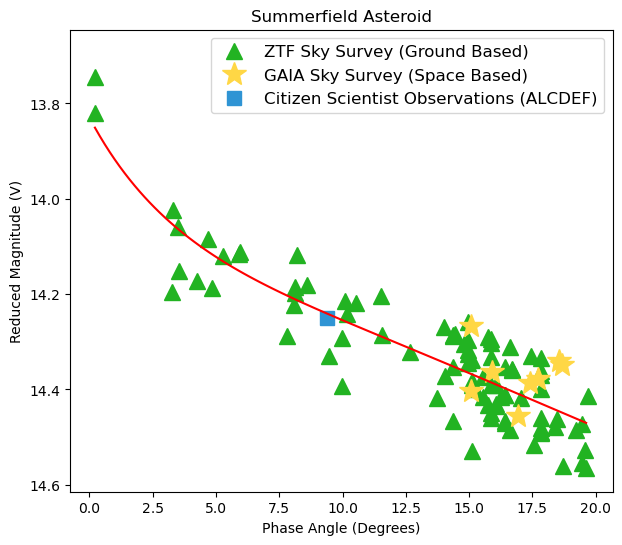

In [203]:
fx=np.linspace(nysa['phase'][0],nysa['phase'][-1],100)
fy=np.array([pf(x,res.x[0],res.x[1]) for x in fx])
#g,p1=plt.subplots(1,1)
plt.figure(figsize=(7, 6))
#plt.plot(nysa['phase'],nysa['V'],'bo')
plt.plot(t1_ZTF,t2_ZTF,'bo', c = '#22b322', marker = '^', markersize=11) #Green
plt.plot(t1_GAIA,t2_GAIA,'bo', c = '#ffd745', marker = '*', markersize=18) #Yellow
plt.plot(t1_ALCDEF[-2:-1],t2_ALCDEF[-2:-1],'bo', c = '#2f94d4', marker = 's', markersize=10) #Blue
plt.legend(['ZTF Sky Survey (Ground Based)', 'GAIA Sky Survey (Space Based)', 'Citizen Scientist Observations (ALCDEF)'], facecolor='w', labelcolor='k', prop = { "size": 12 }, loc ="upper right")
#plt.legend(facecolor='k', labelcolor='w')
plt.plot(fx,fy,'r')
plt.title('Summerfield Asteroid')
plt.xlabel('Phase Angle (Degrees)')
plt.ylabel('Reduced Magnitude (V)')
plt.ylim(max(nysa['V']+0.05), min(nysa['V']-0.1))
plt.show()

C:\Users\vikas\AppData\Local\Temp\ipykernel_68488\909646095.py:63: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(f1_ZTF,f2_ZTF,'bo', c = '#22b322', marker = '^', markersize=11) #Green
C:\Users\vikas\AppData\Local\Temp\ipykernel_68488\909646095.py:63: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(f1_ZTF,f2_ZTF,'bo', c = '#22b322', marker = '^', markersize=11) #Green
C:\Users\vikas\AppData\Local\Temp\ipykernel_68488\909646095.py:64: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(f1_GAIA,f2_GAIA,'bo', c = '#ffd745', marker = '*', markersize=18) #Yellow
C:\Users\vikas\AppData\Local\Temp\ipykernel_68488\909646095.py:64: UserWa

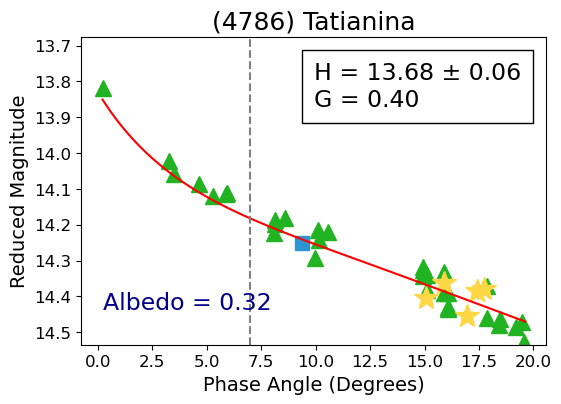

In [212]:
x_specific = nysa['phase'] 
fy_specific = np.array([pf(x, res.x[0], res.x[1]) for x in x_specific])
rmse = np.sqrt(np.mean((nysa['V'] - fy_specific) ** 2))
            

residuals = nysa['V'] - fy_specific
std_dev = np.std(residuals)

within_2_std = np.abs(residuals) <= 1 * std_dev


filtered_ast = nysa[within_2_std]

filtered3_Phase = filtered_ast["phase"]
filtered3_Unity = filtered_ast["V"]
        
f1_ZTF = []
f2_ZTF = []
f1_GAIA = []
f2_GAIA = []

for i in range(len(filtered_ast["phase"])):
    if filtered_ast["phase"][i] in t1_ZTF:
        
        f1_ZTF.append(filtered_ast["phase"][i])
        f2_ZTF.append(filtered_ast["V"][i])

    if filtered_ast["phase"][i] in t1_GAIA:
        
        f1_GAIA.append(filtered_ast["phase"][i])
        f2_GAIA.append(filtered_ast["V"][i])
        

plt.figure(figsize=(6, 4))
#plt.plot(nysa['phase'],nysa['V'],'bo')
f1_ZTF = np.array(f1_ZTF)
f2_ZTF = np.array(f2_ZTF)

#f1_ZTF[30:43] = np.nan
#f2_ZTF[30:43] = np.nan

#f1_ZTF[65:70] = np.nan
#f2_ZTF[65:70] = np.nan

#f1_ZTF[30:80] = np.nan
#f2_ZTF[30:80] = np.nan

#f1_ZTF[100:110] = np.nan
#f2_ZTF[100:110] = np.nan


#t1_ALCDEF = [x - 2 for x in t1_ALCDEF]
#t2_ALCDEF = [x + 0.04 for x in t2_ALCDEF]

plt.plot(f1_ZTF,f2_ZTF,'bo', c = '#22b322', marker = '^', markersize=11) #Green
plt.plot(f1_GAIA,f2_GAIA,'bo', c = '#ffd745', marker = '*', markersize=18) #Yellow
plt.plot(t1_ALCDEF,t2_ALCDEF,'bo', c = '#2f94d4', marker = 's', markersize=10) #Blue

#plt.scatter(nysa[within_2_std]["phase"],nysa[within_2_std]["V"])
#plt.legend(['ZTF Sky Survey', 'GAIA Sky Survey', 'Citizen Scientist Observations (ALCDEF)'], facecolor='w', labelcolor='k', prop = { "size": 15 }, loc ="upper right")
#plt.legend(facecolor='k', labelcolor='w')
plt.plot(fx,fy,'r')
plt.title('(4786) Tatianina', fontsize = 18)
plt.xlabel('Phase Angle (Degrees)', fontsize = 14)
plt.ylabel('Reduced Magnitude', fontsize = 14)
plt.ylim(max(nysa['V'])-0.03, min(nysa['V']-0.07))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axvline(x=7, color='gray', linestyle='--', label='7 degrees') 
plt.text(0.5, 0.92, f'H = {round(13.68, 2)} ± {round(rmse,2)}' + f'\n' + f'G = 0.40', 
         horizontalalignment='left', 
         verticalalignment='top', 
         fontsize=17, 
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='Square, pad=0.5'), 
         transform=plt.gca().transAxes)

plt.text(0.046, 0.1, f'Albedo = 0.32',
         horizontalalignment='left', verticalalignment='bottom', 
         fontsize=17, color='darkblue', 
         transform=plt.gca().transAxes)
plt.show()